In [43]:
import pandas as pd
import seaborn as sns
import numpy as np

import os
import glob

In [44]:
allowed_stems = [
      "drums",
      "lead_male_singer",
      "lead_female_singer",
      # "human_choir",
      "background_vocals",
      # "other_vocals",
      "bass_guitar",
      "bass_synthesizer",
      # "contrabass_double_bass",
      # "tuba",
      # "bassoon",
      "fx",
      "clean_electric_guitar",
      "distorted_electric_guitar",
      # "lap_steel_guitar_or_slide_guitar",
      "acoustic_guitar",
      "other_plucked",
      "pitched_percussion",
      "grand_piano",
      "electric_piano",
      "organ_electric_organ",
      "synth_pad",
      "synth_lead",
      # "violin",
      # "viola",
      # "cello",
      # "violin_section",
      # "viola_section",
      # "cello_section",
      "string_section",
      "other_strings",
      "brass",
      # "flutes",
      "reeds",
      "other_wind"
  ]

In [45]:
TEST_ROOT = os.path.join("/home/kwatchar3/Documents/data", "moisesdb")

TEST_ROOT

'/home/kwatchar3/Documents/data/moisesdb'

In [46]:
results = sorted(glob.glob(os.path.join(TEST_ROOT, "test", "**", "version_*"), recursive=True))
results_o = sorted(glob.glob(os.path.join(TEST_ROOT, "test-o", "**", "version_*"), recursive=True))

test_indices = pd.read_csv(os.path.join("/home/kwatchar3/Documents/data", "moisesdb", "test_indices.csv"))
test_indices = test_indices[test_indices["stem"].isin(allowed_stems)]


In [47]:
metric_names = {
    "TargetDecibels": "db",
    "PredictedDecibels": "db_pred",
    "SafeSignalNoiseRatio": "snr",
    "SafeScaleInvariantSignalNoiseRatio": "sisnr",
}

In [48]:

models = set()


cleaned_df = []
for res in results + results_o:
    metric = pd.read_csv(os.path.join(res, "metrics.csv"))

    if len(metric) != 301:
        continue

    with open(os.path.join(res, "config.txt"), "r") as f:
        config = f.read()

    model = config.split("/lightning_logs")[0].split("/")[-1]
        # print(row_)

    training_stems = model.split("-")[0]
    is_frozen = "fz" in model
    is_augmented = "aug" in model

    variant = "frozen" if is_frozen else "full"
    if is_augmented:
        variant += "-aug"

    is_own_stem = "test-o" in res

    if (model, is_own_stem) in models:
        continue


    models.add((model, is_own_stem))

    print(res)
    print(model)
    print(len(metric))


    for i in range(0, 301):
        row = metric.iloc[i]
        indices = test_indices.iloc[i]

        # print(row.dropna())
        # print(indices)

        song_id = indices["song_id"]
        query = indices["query_id"]
        stem = indices["stem"]

        row_ = row.dropna()

        entry = {
            "song_id": song_id,
            "query_id": query,
            "stem": stem,
            "model": training_stems,
            "frozen": is_frozen,
            "augmented": is_augmented,
            "variant": variant,
            "own_stem": "own" if is_own_stem else "other",
        }

        for metric_name, metric_short in metric_names.items():

            cleaned_df.append({
              **entry,
                "metric": metric_short,
                "value": float(row_[f"test/{stem}/snr/{metric_name}"])
            })


df = pd.DataFrame(cleaned_df)



/home/kwatchar3/Documents/data/moisesdb/test/5326072/lightning_logs/version_0
vdbgp-d-pre
301
/home/kwatchar3/Documents/data/moisesdb/test/5326072/lightning_logs/version_1
vdbgp-d-pre-aug-2
301
/home/kwatchar3/Documents/data/moisesdb/test/5326072/lightning_logs/version_2
vdbgp-d-pre-fz-2
301
/home/kwatchar3/Documents/data/moisesdb/test/lightning_logs/version_0
everything-d-prefz-2
301
/home/kwatchar3/Documents/data/moisesdb/test/lightning_logs/version_3
vdb-d-pre
301
/home/kwatchar3/Documents/data/moisesdb/test/lightning_logs/version_4
everything-d-pre
301
/home/kwatchar3/Documents/data/moisesdb/test/lightning_logs/version_6
vdb-d-pre-aug
301
/home/kwatchar3/Documents/data/moisesdb/test/lightning_logs/version_7
everything-d-pre-aug-2
301
/home/kwatchar3/Documents/data/moisesdb/test/lightning_logs/version_9
vdb-d-pre-fz-2
301
/home/kwatchar3/Documents/data/moisesdb/test-o/5340679/lightning_logs/version_0
vdbgp-d-pre
301
/home/kwatchar3/Documents/data/moisesdb/test-o/5340680/lightning_lo

In [49]:
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

In [50]:
allowed_stems_with_count = df.groupby("stem")[["song_id"]].count().index.tolist()

allowed_stems_with_count

['acoustic_guitar',
 'background_vocals',
 'bass_guitar',
 'bass_synthesizer',
 'brass',
 'clean_electric_guitar',
 'distorted_electric_guitar',
 'drums',
 'electric_piano',
 'fx',
 'grand_piano',
 'lead_female_singer',
 'lead_male_singer',
 'organ_electric_organ',
 'pitched_percussion',
 'reeds',
 'string_section',
 'synth_lead',
 'synth_pad']

In [51]:
stem_dtype = pd.CategoricalDtype(categories=[
    a for a in allowed_stems if a in allowed_stems_with_count
], ordered=True)

variant_dtype = pd.CategoricalDtype(categories=[
    "frozen", "full", "full-aug"
], ordered=True)

training_stems_dtype = pd.CategoricalDtype(categories=[
    "vdb", "vdbgp", "everything"
], ordered=True)

df = df.astype({
    "stem": stem_dtype,
    "variant": variant_dtype,
    "model": training_stems_dtype
})

In [52]:
stem_count = df.groupby("stem")[["song_id"]].count().reset_index().to_dict(orient="records")
stem_count = {a["stem"]: a["song_id"] for a in stem_count}
# stem_count

/tmp/ipykernel_4115695/686738495.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  stem_count = df.groupby("stem")[["song_id"]].count().reset_index().to_dict(orient="records")


In [53]:
medians = df.groupby(["model", "variant", "stem", "metric", "own_stem"])["value"].median()


/tmp/ipykernel_4115695/1005620044.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  medians = df.groupby(["model", "variant", "stem", "metric", "own_stem"])["value"].median()


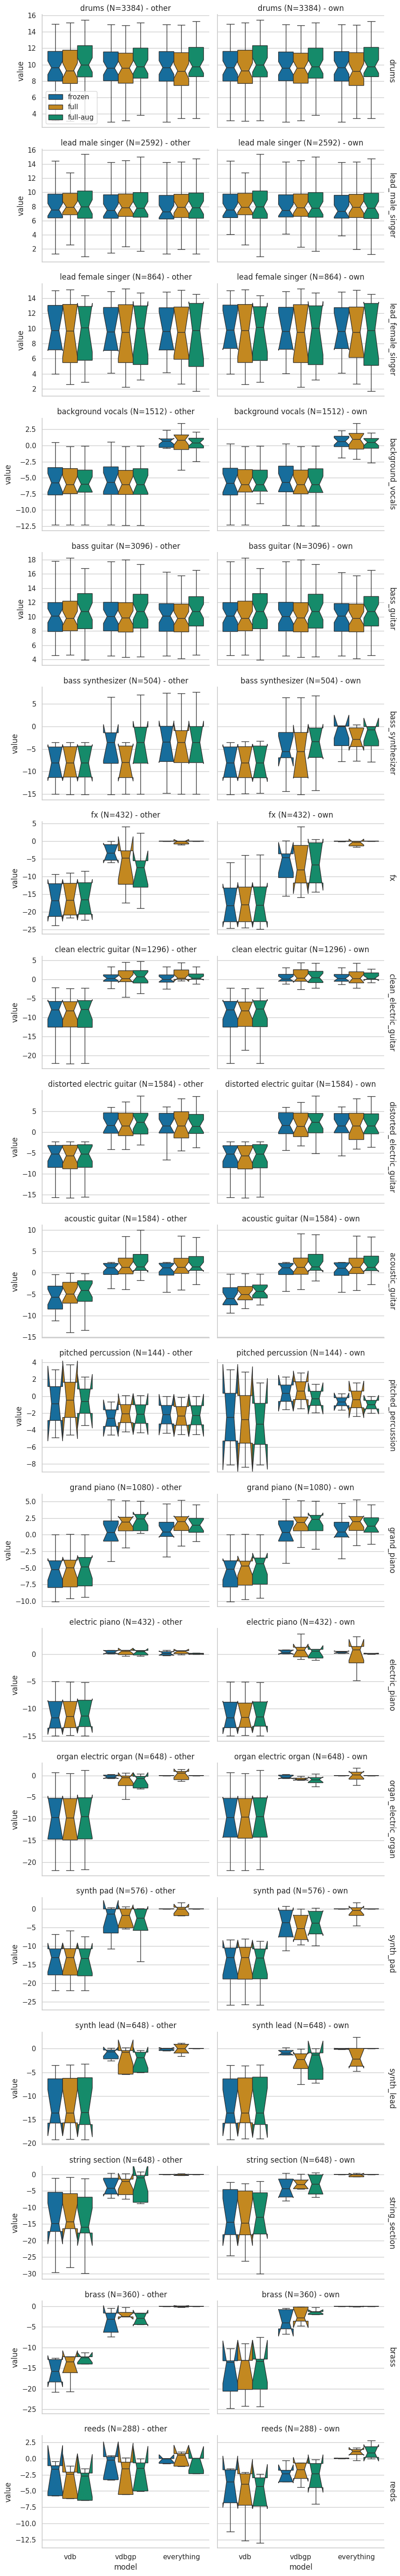

In [54]:
df = df.sort_values(["model", "variant"])


def format_stem(stem):
    stem_ = stem.replace("_", " ")
    return f"{stem_} (N={stem_count[stem]})"

formatted_stem_dtype = pd.CategoricalDtype(categories=[
    format_stem(s) for s in stem_dtype.categories
], ordered=True)

df["formatted_stem"] = df["stem"].apply(format_stem).astype(formatted_stem_dtype)


g = sns.FacetGrid(
    df[df.metric == "snr"],
    col="own_stem",
    row="stem",
    margin_titles=True,
    aspect=1.5,
    sharey="row",
    sharex=True,
    legend_out=False,
)
g.map_dataframe(sns.boxplot,
                x="model",
                y="value",
                hue="variant",
                notch=True,
                palette="colorblind",
                showfliers=False,)

g.set_titles(row_template="{row_name}", col_template="{col_name}")

for (stem, metric), ax in g.axes_dict.items():

    ax.set_title(format_stem(stem) + f" - {metric}")

g.add_legend()

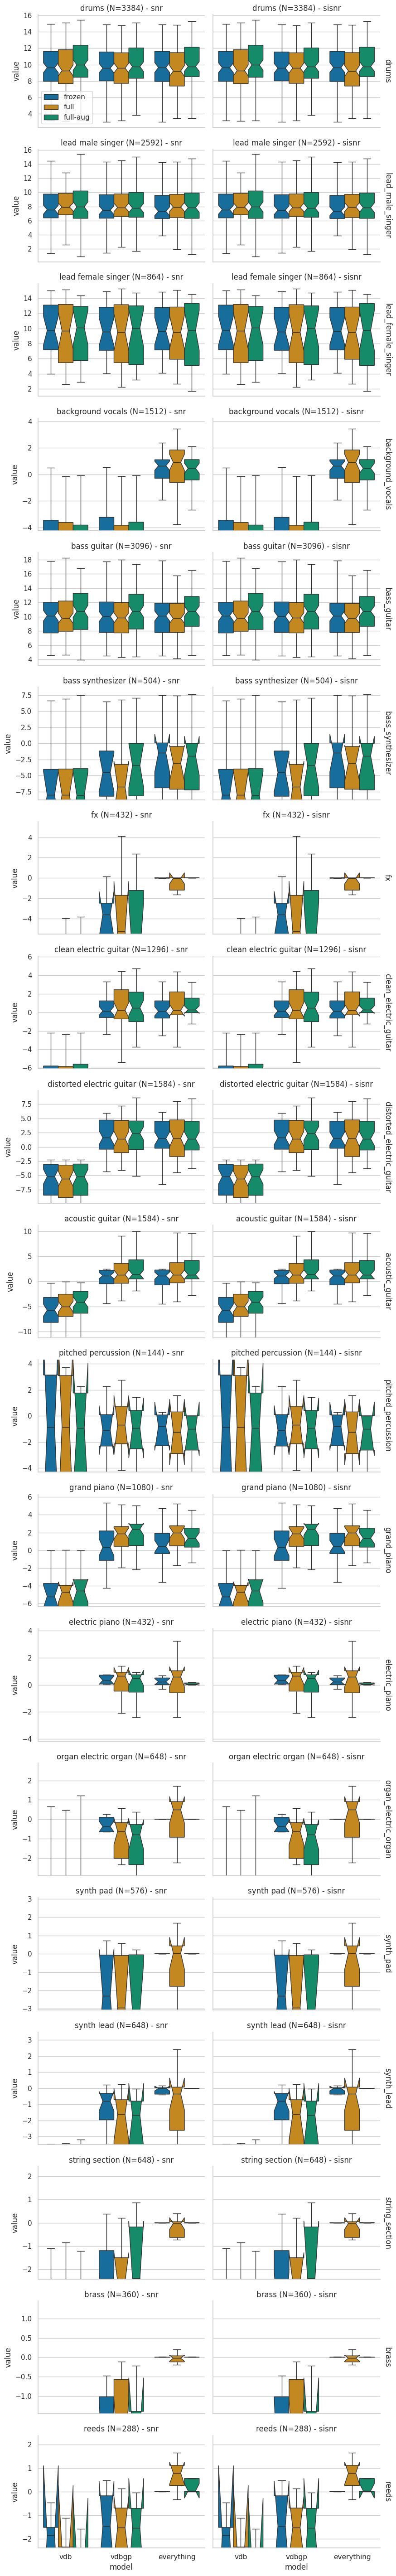

In [55]:
f = df.sort_values(["model", "variant"])


def format_stem(stem):
    stem_ = stem.replace("_", " ")
    return f"{stem_} (N={stem_count[stem]})"

formatted_stem_dtype = pd.CategoricalDtype(categories=[
    format_stem(s) for s in stem_dtype.categories
], ordered=True)

df["formatted_stem"] = df["stem"].apply(format_stem).astype(formatted_stem_dtype)


g = sns.FacetGrid(
    df[df.metric.str.contains("snr")],
    col="metric",
    row="stem",
    margin_titles=True,
    aspect=1.5,
    sharey="row",
    sharex=True,
    legend_out=False,
)
g.map_dataframe(sns.boxplot,
                x="model",
                y="value",
                hue="variant",
                notch=True,
                palette="colorblind",
                showfliers=False,)

g.set_titles(row_template="{row_name}", col_template="{col_name}")

for (stem, metric), ax in g.axes_dict.items():

    ax.set_title(format_stem(stem) + f" - {metric}")
    [ymin, ymax] = ax.get_ylim()

    if ymax > 0:
        ymin_ = -ymax
    else:
        ymin_ = ymin

    ax.set_ylim([max(ymin_, ymin), ymax])

g.add_legend()

In [56]:
medians_snr = medians.reset_index()

medians_snr = medians_snr[medians_snr["metric"] == "snr"]

medians_snr = medians_snr.pivot_table(columns=["model", "variant", "own_stem"], index="stem", values="value")

medians_snr = medians_snr.round(2)



import dataframe_image as dfi

dfi.export((medians_snr.style
    .background_gradient(cmap="RdBu", axis=None)
    .format("{:-2.2f}")
 ), "medians_snr.png")

In [57]:
means_snr = df.groupby(["model", "variant", "stem", "metric"])["value"].mean()

means_snr = means_snr.reset_index()

means_snr = means_snr[means_snr["metric"] == "snr"]

means_snr = means_snr.pivot_table(columns=["model", "variant"], index="stem", values="value")

means_snr = means_snr.round(2)

dfi.export((means_snr.style
    .background_gradient(cmap="RdBu", axis=None)
    .format("{:-2.2f}")
 ), "means_snr.png")

/tmp/ipykernel_4115695/2163472369.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_snr = df.groupby(["model", "variant", "stem", "metric"])["value"].mean()


In [58]:
df["model_variant"] = df.apply(lambda x: f"{x['model']} ({x['variant']})", axis=1)

df_wide = df.pivot_table(columns=["metric"], index=["model", "variant", "stem", "song_id"], values="value").reset_index()

df_wide

metric,model,variant,stem,song_id,db,db_pred,sisnr,snr
0,vdb,frozen,drums,0358fd1e-244a-4422-9a42-29b5d68f6e4b,-30.732943,-31.770389,3.175025,3.175025
1,vdb,frozen,drums,05e7af85-9721-4b42-952a-ccd34feb6033,-29.699234,-30.644718,8.918266,8.918266
2,vdb,frozen,drums,06bfc6e7-e5ac-4827-bf8e-ffaf1675872f,-32.372391,-32.805096,8.730032,8.730032
3,vdb,frozen,drums,07fb2df2-91d6-458d-9230-9638b4edac08,-29.801800,-29.907924,12.074795,12.074795
4,vdb,frozen,drums,0d528a19-cb0f-4421-b250-444f9343e51c,-25.349489,-25.989076,9.815261,9.815261
...,...,...,...,...,...,...,...,...
2704,everything,full-aug,brass,fc3c9e48-e2ac-4088-af65-68404baa7f12,-42.253304,-59.992407,0.003243,0.003243
2705,everything,full-aug,reeds,125fc63d-9b69-4170-a46a-42c91bc28446,-32.792183,-47.966997,1.403564,1.403564
2706,everything,full-aug,reeds,78ef22ce-472f-4f82-8656-16df73b9465f,-30.358189,-48.623161,0.769421,0.769421
2707,everything,full-aug,reeds,7bfa233c-24ed-4c7a-9096-11e3aa00c55d,-46.080410,-48.768347,-4.674554,-4.674554


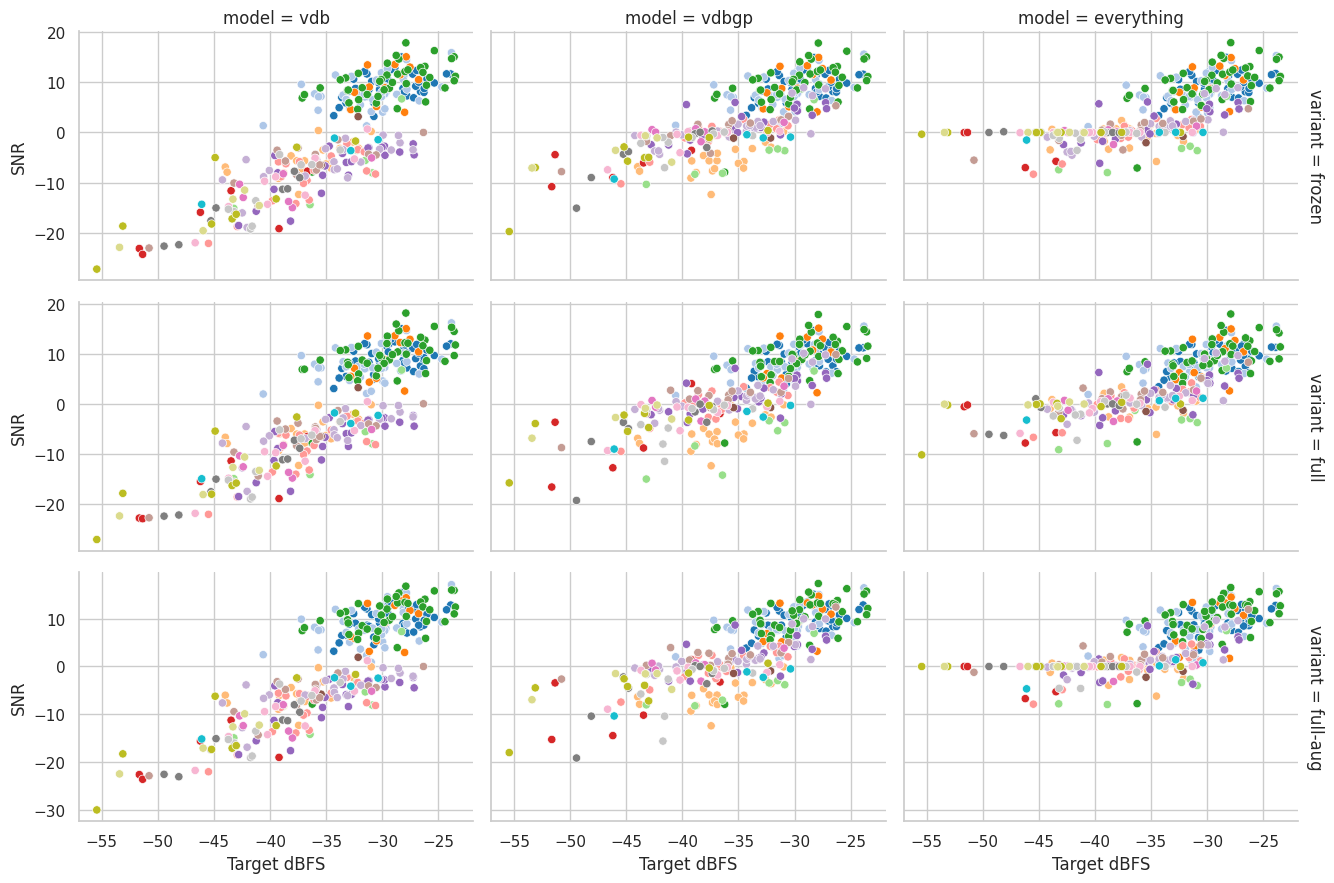

In [59]:
g = sns.FacetGrid(
    df_wide,
    col="model",
    row="variant",
    margin_titles=True,
    aspect=1.5,
    sharey="row",
    sharex=True,
    legend_out=False,
)

g.map_dataframe(sns.scatterplot, x="db", y="snr", hue="stem", palette="tab20")
g.set_xlabels("Target dBFS")
g.set_ylabels("SNR")


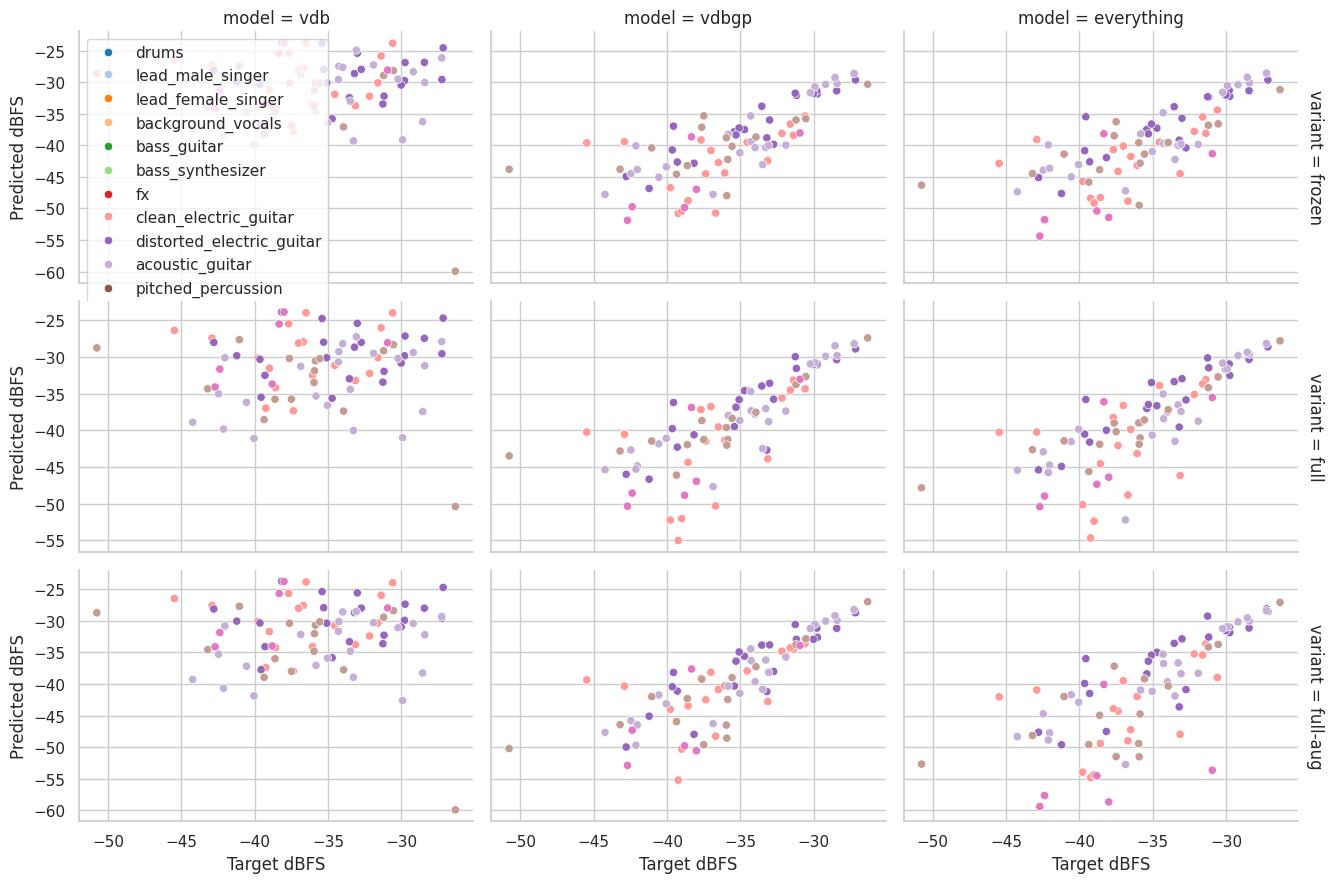

In [69]:
vdb_stems = [
    "drums",
    "bass_guitar",
    "lead_female_singer",
    "lead_male_singer",
]
vdbgp_stems = [
    "clean_electric_guitar",
    "distorted_electric_guitar",
    # "lap_steel_guitar_or_slide_guitar",
    "acoustic_guitar",
    "grand_piano",
    "electric_piano",
]

g = sns.FacetGrid(
    df_wide[df_wide["stem"].isin(vdbgp_stems)],
    col="model",
    row="variant",
    margin_titles=True,
    aspect=1.5,
    sharey="row",
    sharex=True,
    legend_out=False,
)

g.map_dataframe(sns.scatterplot, x="db", y="db_pred", hue="stem", palette="tab20")
g.set_xlabels("Target dBFS")
g.set_ylabels("Predicted dBFS")
g.add_legend()